# INTRODUCTION

This Notebook will try to analyze the data of the COVID-19 pandemic over time. We conduct linear regression on world data to predict two aspect: number of new_deaths_per_million and new_cases_per_minilion 

**TEAM MEMBERS**

*   Bach Duong Yen Linh
*   Vuong Do Tuan Thanh
*   Do Bui Khanh Linh

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler

In [ ]:
url = "https://raw.githubusercontent.com/linhbdy/MATH4010_CovidDataset/main/owid-2022-clean.csv"
df = pd.read_csv(url)

# 1. DATA PREPARATION

Use df.info() to check initial datatypes and number of null values in each column. It appears that the data type of all columns are fine, but there are many missing values.

In [ ]:
#Count the number of null data in each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1323 entries, 0 to 1322
Data columns (total 31 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   iso_code                             1323 non-null   object 
 1   continent                            1323 non-null   object 
 2   location                             1323 non-null   object 
 3   date                                 1323 non-null   object 
 4   total_cases_per_million              1316 non-null   float64
 5   new_cases_per_million                1316 non-null   float64
 6   total_deaths_per_million             1295 non-null   float64
 7   new_deaths_per_million               1293 non-null   float64
 8   new_tests_smoothed_per_thousand      940 non-null    float64
 9   positive_rate                        879 non-null    float64
 10  tests_per_case                       878 non-null    float64
 11  tests_units                   

**1.1 Choosing columns to keep and drop**

First, we want to drop columns that have an overwhelming number of null data. This is done by running a for loop over all columns and select those missing more than half of the dataset's length. The other existing entries are not representative enough to effectively substitute for the null ones. From the output of the for loop, we will drop: *people_vaccinated_per_hundred, people_fully_vaccinated_per_hundred, total_boosters_per_hundred*, and *handwashing_facilities*.

It is unfortunate that we have to drop columns that relate especially to vaccination and hygiene, 2 important indicators of Covid response. According to [Reuters](https://graphics.reuters.com/world-coronavirus-tracker-and-maps/vaccination-rollout-and-access/), OurWorldInData only input values for the vaccination-related columns if the respective countries reported the number of vaccinated people. If the countries reported the total number of vaccine doses administered, they will be excluded from this dataset. Also, many government mixed up between the number of people vaccinated with at least 1 dose and the number of fully vaccinated people. This explains the overwhelming amount of null entries. It is such a shame to exclude them from our model, but at least now we know the reasons why.

In [ ]:
for i in df.columns.tolist():
  if df[i].isnull().sum() > len(df)//2:
    print(f"{i:<35}{df[i].isnull().sum():>10}")

people_vaccinated_per_hundred             734
people_fully_vaccinated_per_hundred       717
total_boosters_per_hundred                856
handwashing_facilities                    672


Based on logical reasoning, we drop some other columns:

*   *iso_code, location, tests_units, population*: 1st step of the data preparation requirements.
*   *extreme_poverty*: has too many null values. The information it provides (e.g. standards of living) overlaps with *gdp_per_capita*
*   *total_cases_per_million, total_deaths_per_million*: increases in these columns also mean increases in *new_cases_per_million* and *new_deaths_per_million*. This is a directly linear correlation, so these columns can be dropped.
*   *aged_70_older*: does not provide any new information compared to *aged_65_older*. We also have parameter life_expectancy to represent the level of healthcare for old people.

Notice that the dataset has separate columns for *male_smokers* and *female_smokers*. However, the columns that we want to predict, *new_cases_per_million* and *new_deaths_per_million*, are not categorized by gender. Thus, we can combine these 2 columns into one column, smokers, and drop the original ones.

In [ ]:
df['smokers'] = df['female_smokers'] + df['male_smokers']
df.drop(['iso_code', 'total_cases_per_million', 'total_deaths_per_million', 'tests_units', 'population', 'handwashing_facilities', 'extreme_poverty', 'aged_70_older', 'female_smokers', 'male_smokers', 'total_boosters_per_hundred', 'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred'], axis=1, inplace=True)
df.head(7)

,continent,location,date,new_cases_per_million,new_deaths_per_million,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,stringency_index,population_density,median_age,aged_65_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,hospital_beds_per_thousand,life_expectancy,human_development_index,smokers
0,Asia,Afghanistan,2/1/2022,15.790,0.075,NaN,NaN,NaN,19.44,54.422,18.6,2.581,1803.987,597.029,9.59,0.5,64.83,0.511,NaN
1,Asia,Afghanistan,2/2/2022,15.941,0.025,NaN,NaN,NaN,19.44,54.422,18.6,2.581,1803.987,597.029,9.59,0.5,64.83,0.511,NaN
2,Asia,Afghanistan,2/3/2022,13.480,0.050,NaN,NaN,NaN,19.44,54.422,18.6,2.581,1803.987,597.029,9.59,0.5,64.83,0.511,NaN
3,Asia,Afghanistan,2/4/2022,15.840,0.000,NaN,NaN,NaN,19.44,54.422,18.6,2.581,1803.987,597.029,9.59,0.5,64.83,0.511,NaN
4,Asia,Afghanistan,2/5/2022,8.861,0.126,0.033,0.4855,2.1,19.44,54.422,18.6,2.581,1803.987,597.029,9.59,0.5,64.83,0.511,NaN
5,Asia,Afghanistan,2/6/2022,12.050,0.176,0.033,0.4480,2.2,19.44,54.422,18.6,2.581,1803.987,597.029,9.59,0.5,64.83,0.511,NaN
6,Asia,Afghanistan,2/7/2022,18.401,0.251,0.033,0.4390,2.3,19.44,54.422,18.6,2.581,1803.987,597.029,9.59,0.5,64.83,0.511,NaN


We can see that Afghanistan is missing values for the first 4 days. Many other countries are missing data for all or some of the 7 days as well.
Perhaps, these countries report figures once every few days. We also observe that figures for consecutive days differ very slightly.

**1.2 Filling in missing data using week average**

From the observation that data of consecutive days does not differ significantly, we decide to replace null entries with their respective country's 7-day average. Our observation ensures that the substitution method is safe and does not make a huge difference to the distribution of the original dataset.

In [ ]:
# This is a function to replace NaN values with 7-day mean

def fill_by_mean_7d(col):
  for i in range(0, len(col), 7):
    mean_7d = col.iloc[i:i+7].mean()
    col.iloc[i:i+7].fillna(mean_7d, inplace=True)
  return col

cols = [col for col in df.columns if col != 'location' and col != 'continent' and col != 'date' and df[col].isnull().sum() != 0]
for c in cols:
  df[c] = fill_by_mean_7d(df[c])

df.head(7)

,continent,location,date,new_cases_per_million,new_deaths_per_million,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,stringency_index,population_density,median_age,aged_65_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,hospital_beds_per_thousand,life_expectancy,human_development_index,smokers
0,Asia,Afghanistan,2/1/2022,15.790,0.075,0.033,0.4575,2.2,19.44,54.422,18.6,2.581,1803.987,597.029,9.59,0.5,64.83,0.511,NaN
1,Asia,Afghanistan,2/2/2022,15.941,0.025,0.033,0.4575,2.2,19.44,54.422,18.6,2.581,1803.987,597.029,9.59,0.5,64.83,0.511,NaN
2,Asia,Afghanistan,2/3/2022,13.480,0.050,0.033,0.4575,2.2,19.44,54.422,18.6,2.581,1803.987,597.029,9.59,0.5,64.83,0.511,NaN
3,Asia,Afghanistan,2/4/2022,15.840,0.000,0.033,0.4575,2.2,19.44,54.422,18.6,2.581,1803.987,597.029,9.59,0.5,64.83,0.511,NaN
4,Asia,Afghanistan,2/5/2022,8.861,0.126,0.033,0.4855,2.1,19.44,54.422,18.6,2.581,1803.987,597.029,9.59,0.5,64.83,0.511,NaN
5,Asia,Afghanistan,2/6/2022,12.050,0.176,0.033,0.4480,2.2,19.44,54.422,18.6,2.581,1803.987,597.029,9.59,0.5,64.83,0.511,NaN
6,Asia,Afghanistan,2/7/2022,18.401,0.251,0.033,0.4390,2.3,19.44,54.422,18.6,2.581,1803.987,597.029,9.59,0.5,64.83,0.511,NaN


Now, Afghanistan's missing values for the first 4 days have been replaced by its average over the week. Notice that the last column, smokers, are still filled with NaN. Initially, Afghanistan does not have information for smokers, thus the average of NaN is just NaN. We will deal with this case in a later step.

**1.3 Smoothing out data**

In reality, we can have days in which there is a sudden spike in the number of new cases, deaths, and tests. For example, a new policy or an improvement in testing facilities can result in more people tested, thus more number of new cased being discovered. To get a more representative picture, we should average the fields *new_deaths_per_million,  new_cases_per_million*, and *new_tests_smoothed_per_thousand*  over 7 days.

The remaining columns (e.g. population_density, median_age, gpd_per_capita, etc) are pretty much constant over the week, hence there is no need for smoothing out.

Since we only do regression on day 7/2/2022, the week average is plugged into the value for this specific day. 

In [ ]:
cols_to_weak_avg = ['new_cases_per_million', 'new_deaths_per_million', 'new_tests_smoothed_per_thousand']
for c in cols_to_weak_avg:
  m = df[c] != 0
  d = df['date'] == '2/7/2022'
  s = df[m].groupby('location')[c].mean()
  df.loc[d, c] = df['location'].map(s)

In [ ]:
df.head(7)

,continent,location,date,new_cases_per_million,new_deaths_per_million,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,stringency_index,population_density,median_age,aged_65_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,hospital_beds_per_thousand,life_expectancy,human_development_index,smokers
0,Asia,Afghanistan,2/1/2022,15.790000,0.075000,0.033,0.4575,2.2,19.44,54.422,18.6,2.581,1803.987,597.029,9.59,0.5,64.83,0.511,NaN
1,Asia,Afghanistan,2/2/2022,15.941000,0.025000,0.033,0.4575,2.2,19.44,54.422,18.6,2.581,1803.987,597.029,9.59,0.5,64.83,0.511,NaN
2,Asia,Afghanistan,2/3/2022,13.480000,0.050000,0.033,0.4575,2.2,19.44,54.422,18.6,2.581,1803.987,597.029,9.59,0.5,64.83,0.511,NaN
3,Asia,Afghanistan,2/4/2022,15.840000,0.000000,0.033,0.4575,2.2,19.44,54.422,18.6,2.581,1803.987,597.029,9.59,0.5,64.83,0.511,NaN
4,Asia,Afghanistan,2/5/2022,8.861000,0.126000,0.033,0.4855,2.1,19.44,54.422,18.6,2.581,1803.987,597.029,9.59,0.5,64.83,0.511,NaN
5,Asia,Afghanistan,2/6/2022,12.050000,0.176000,0.033,0.4480,2.2,19.44,54.422,18.6,2.581,1803.987,597.029,9.59,0.5,64.83,0.511,NaN
6,Asia,Afghanistan,2/7/2022,14.337571,0.117167,0.033,0.4390,2.3,19.44,54.422,18.6,2.581,1803.987,597.029,9.59,0.5,64.83,0.511,NaN


Now, *new_deaths_per_million,  new_cases_per_million*, and *new_tests_smoothed_per_thousand* of day 2/7/2022 of Afghanistan has already been filled with its week average.

In [ ]:
deaths_null = df[df['new_deaths_per_million'].isnull()]
deaths_null

,continent,location,date,new_cases_per_million,new_deaths_per_million,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,stringency_index,population_density,median_age,aged_65_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,hospital_beds_per_thousand,life_expectancy,human_development_index,smokers
132,Africa,Benin,2/7/2022,3.855000,NaN,NaN,NaN,NaN,55.56,99.110,18.8,3.244,2064.236,235.848,0.99,0.50,61.77,0.545,12.9
146,Asia,Bhutan,2/7/2022,258.091714,NaN,12.689000,0.0268,37.3,75.46,21.188,28.6,4.885,8708.597,217.066,9.75,1.70,71.78,0.654,NaN
181,Asia,Brunei,2/7/2022,948.968500,NaN,NaN,NaN,NaN,57.41,81.347,32.4,4.591,71809.251,201.285,12.79,2.70,75.86,0.838,32.9
202,Africa,Burundi,2/7/2022,8.431333,NaN,0.216286,0.0170,58.8,19.44,423.062,17.5,2.562,702.225,293.068,6.05,0.80,61.58,0.433,NaN
209,Asia,Cambodia,2/7/2022,4.434000,NaN,0.203000,0.0219,45.7,35.65,90.672,25.6,4.412,3645.070,270.892,4.00,0.80,69.82,0.594,35.7
244,Africa,Central African Republic,2/7/2022,21.138000,NaN,0.022143,0.1790,5.6,18.52,7.479,18.3,3.655,661.240,435.727,6.10,1.00,53.28,0.397,NaN
251,Africa,Chad,2/7/2022,1.744000,NaN,0.020286,0.0247,40.5,32.41,11.833,16.7,2.486,1768.153,280.995,6.10,NaN,54.24,0.398,NaN
265,Asia,China,2/7/2022,0.070143,NaN,10.227000,0.0000,145618.9,64.35,147.674,38.7,10.641,15308.712,261.899,9.74,4.34,76.91,0.761,50.3
279,Africa,Comoros,2/7/2022,29.714600,NaN,NaN,NaN,NaN,NaN,437.352,20.4,2.963,1413.890,261.516,11.88,2.20,64.32,0.554,28.0
349,Africa,Djibouti,2/7/2022,9.977833,NaN,NaN,NaN,NaN,49.07,41.285,25.4,4.213,2705.406,258.037,6.05,1.40,67.11,0.524,26.2


In [ ]:
for i in range(0, len(df), 7):
    mean_7d = (df.iloc[i:i+7])['new_cases_per_million'].mean()
    if mean_7d == 0:
      print(df.iloc[i:i+7].location.unique())

['El Salvador']
['Honduras']
['Tanzania']
['Vanuatu']


Next, we check for null values in the columns that we need to predict: *new_cases_per_million* and *new_deaths_per_million*. It appears that most of the null values for these 2 fields come from small island nations. This is explanable considering that these countries are too isolated (especially when there is a global travel restriction) to catch a Covid outbreak. Therefore, their figures are very low and tend to stay constant throughout the week (e.g. Samoa, Tonga). Some countries seem to have very inefficient health statistics agencies since they report no data (e.g. Vanuatu, United States Virgin Islands). Despite missing a whole week of data for new deaths, Kiribati is an exception since its new cases are just too high for an island nation. Else, these countries are missing significantly important entries, so they provide no useful information and we decided to drop them.

Besides null values, zeros for new cases are also suspicious in a global pandemic. We select countries that report no new cases across 7 days by checking if the average number of new cases is 0. Either these countries are not going through any impacts of Covid at all, or their government is hiding statistics. We do not know which case is true, so it is better to remove them. The countries are: El Salvador, Honduras, Tanzania, and Vanuatu.

In [ ]:
countries_to_drop = ['Samoa', 'Tonga', 'Vanuatu', 'United States Virgin Islands', 'El Salvador', 'Honduras', 'Tanzania']
df = df[~df['location'].isin(countries_to_drop)]

**1.4 Converting categorial fields into a set of boolean**

So far, we have drop columns, delete countries, and replace NaN values with week average by location. However, many countries still have their data missing for all 7 days. Instead of using average of the whole dataset, here, we are going to make a big assumption that countries of the same continent behave similarly. We will use continent averages to fill in NaN values. For example, the NaN values for Afghanistan's *smokers* column will be replaced by the mean of *smokers* of all Asian countries.

Finally, we convert categorial column *continent* into dummy variables, creating new columns with boolean values for continent names (e.g. *continent_Asia, continent_Africa*, etc). The original column *continent* is automatically removed.

After finishing data transformation steps, columns *location* and *date* are no longer needed, so drop them. Now, the dataset does not have any null entries, and it is ready for regression.

In [ ]:
for c in cols:
  df[c] = df.groupby("continent")[c].transform(lambda x: x.fillna(x.mean()))

df = pd.get_dummies(df, columns = ['continent'])
df.drop(['location', 'date'], axis=1, inplace=True)
df.isnull().sum()

new_cases_per_million              0
new_deaths_per_million             0
new_tests_smoothed_per_thousand    0
positive_rate                      0
tests_per_case                     0
stringency_index                   0
population_density                 0
median_age                         0
aged_65_older                      0
gdp_per_capita                     0
cardiovasc_death_rate              0
diabetes_prevalence                0
hospital_beds_per_thousand         0
life_expectancy                    0
human_development_index            0
smokers                            0
continent_Africa                   0
continent_Asia                     0
continent_Europe                   0
continent_North America            0
continent_Oceania                  0
continent_South America            0
dtype: int64

#2. MODELLING
First, we drop all rows from day 2/1/2022 to day 2/6/2022, as well as 2 columns that we are going to predict: *new_cases_per_million* and *new_deaths_per_million*. Then, apply a MinMaxScaler to the new dataframe to normalize all features into the range [0, 1], allowing each feature to contribute equally to model fitting later. 

In [ ]:
# training with multiple linear regression model in sklearn
mlr = LinearRegression()

df = df.drop(labels=df[df.index % 7 != 6].index, axis=0)
df = df.reset_index()
X= df.drop(['new_cases_per_million','new_deaths_per_million', 'index'], inplace = False, axis = 1)
Y= df[['new_cases_per_million','new_deaths_per_million']].to_numpy()

X= MinMaxScaler().fit_transform(X)

mlr.fit(X, Y)

LinearRegression()

In [ ]:
Y_pred_mlr = mlr.predict(X)

# prediction performance for new cases per million
print("New cases per million")
mlr_case_diff = pd.DataFrame({'Actual value': Y[:, 0], 'Predicted value': Y_pred_mlr[:, 0]})
print(mlr_case_diff.head())

# prediction performance for new deaths per million
print()
print("New deaths per million")
mlr_death_diff = pd.DataFrame({'Actual value': Y[:, 1], 'Predicted value': Y_pred_mlr[:, 1]})
print(mlr_death_diff.head())

New cases per million
   Actual value  Predicted value
0     14.337571      1116.087010
1    551.004750      2357.588931
2     20.367143      1257.078942
3   2747.110750      4099.019059
4      1.233429      -309.869661

New deaths per million
   Actual value  Predicted value
0      0.117167         0.239773
1      3.568000         8.992292
2      0.240143         4.446185
3     12.928000         8.726242
4      0.029000        -0.188540


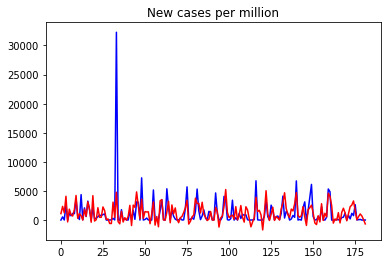

In [ ]:
plt.plot(Y[:, 0], color = 'blue'), plt.plot(Y_pred_mlr[:, 0], color = 'red')
plt.title("New cases per million")
plt.show()

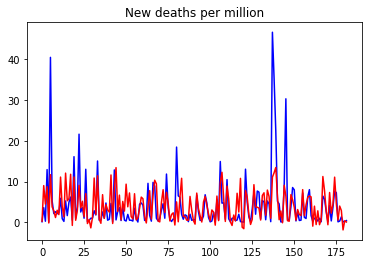

In [ ]:
plt.plot(Y[:, 1], color = 'blue'), plt.plot(Y_pred_mlr[:, 1], color = 'red')
plt.title("New deaths per million")
plt.show()

Visually, we can see that our linear regression fits quite well to the actually numbers. It can trace approximately close to rises and drops, but fails to fit sudden spikes in the original datasets. These spike moments can be considered as outliers, which can be ignored when evaluating the performance of our regression model.

# P-VALUE INTERPRETATION

In [ ]:
X= df.drop(['new_cases_per_million','new_deaths_per_million', 'index'], inplace = False, axis = 1)

X[list(X.columns)] = MinMaxScaler().fit_transform(X)
X2 = sm.add_constant(X)

est = sm.OLS(Y[:, 0], X2)
est_case = est.fit()

print(est_case.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     3.101
Date:                Sat, 04 Jun 2022   Prob (F-statistic):           5.02e-05
Time:                        16:56:08   Log-Likelihood:                -1674.4
No. Observations:                 182   AIC:                             3389.
Df Residuals:                     162   BIC:                             3453.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
est = sm.OLS(Y[:, 1], X2)
est_death = est.fit()

print(est_death.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     4.156
Date:                Sat, 04 Jun 2022   Prob (F-statistic):           2.34e-07
Time:                        16:56:08   Log-Likelihood:                -566.02
No. Observations:                 182   AIC:                             1172.
Df Residuals:                     162   BIC:                             1236.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

The p-values can be seen from the column "P > |t|". For each field, its p-value gives information about the null hypothesis that it and the dependent value (*new_cases_per_million* or *new_deaths_per_million*) has no correlation.

If the p-value for a field is lower than the level of significance, there is enough evidence to reject the null hypothesis for the entire population. Thus, this field is statistically significant and proves itself as a worthwhile parameter for the regression model. We will carry out step-wise regression in the next part.

For example, looking at the first table (statistics of *new_cases_per_million*), if we assume a threshold of 0.05, fields with a corresponding p-value of less than 0.2 will be statistically significant. Such fields are: *gdp_per_capita, life_expectancy*.

In the first table (statistics of *new_cases_per_million*), we can see that columns with the lowest p-values are *gpd_per_capita* (0.007), *life_expectancy* (0.015), and *positive_rate* (0.112). It makes sense why they are good candidates for statistical significance. High values for GDP per capita and life expectancy corresponds to an overall high living standards for people of a country who have better access to healthcare and hygienic living environment. A high positive rate, obviously, is an indicator of an outbreak happening in a country which implies a high number of new cases. Surprisingly, *stringency_index* has the highest p-value of all. Since a high stringency index means stricter response by the government to a Covid outbreak, would its high p-value imply an ineffectiveness of governments around the world in controlling Covid? Anyway, this makes a good topic for further investigation.

In the second table (statistics for *new_deaths_per_million*), we can see that columns with the lowest p-values are continent_NorthAmerica (0.000), continent_Asia (0.001), and diabetes_prevalence (0.082). We can infer that diabetes is likely a factor causing death for a Covid patient. The 2 continent fields relate closely with Covid new deaths, perhaps, because these continents contribute the most to the number of new deaths globally? Again, this is difficult to explain rightaway, which makes another good topic for further investigation. 

# STEP-WISE REGRESSION

In [ ]:
#step-wise regression function

def forward_regression(X, y, threshold_in):
    #Return a list containing selected features
    initial_list = []
    included = list(initial_list)
    while True:
        changed=False
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True

        if not changed:
            break

    return included

def backward_regression(X, y, threshold_out):
    #Return a list containing selected features
    included=list(X.columns)
    while True:
        changed=False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            
        if not changed:
            break
    
    return included

In [ ]:
X = df.drop(['new_cases_per_million','new_deaths_per_million', 'index'], inplace = False, axis = 1)
Y_case = df['new_cases_per_million']
Y_death = df['new_deaths_per_million']

#choose the threshold to be 0.1
fw_case = forward_regression(X, Y_case, 0.1)
bw_case = backward_regression(X, Y_case, 0.1)

fw_death = forward_regression(X, Y_death, 0.1)
bw_death = backward_regression(X, Y_death, 0.1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
print("New cases per million: \nFeatures selected using:")
print("Forward stepwise: ", fw_case)
print("Using backward stepwise: ", bw_case)
print("In forward but not in backward:", set(fw_case) - set(bw_case))
print("In backward but not in forward:", set(bw_case) -set(fw_case))

print("\nNew deaths per million:")
print("Using forward stepwise: ", fw_death)
print("Using backward stepwise: ", bw_death)
print("In forward but not in backward:", set(fw_death) - set(bw_death))
print("In backward but not in forward:", set(bw_death) - set(fw_death))

New cases per million: 
Features selected using:
Forward stepwise:  ['life_expectancy', 'continent_Asia', 'gdp_per_capita']
Using backward stepwise:  ['positive_rate', 'gdp_per_capita', 'life_expectancy', 'human_development_index', 'continent_Asia']
In forward but not in backward: set()
In backward but not in forward: {'human_development_index', 'positive_rate'}

New deaths per million:
Using forward stepwise:  ['continent_North America', 'median_age', 'continent_Asia', 'diabetes_prevalence', 'positive_rate']
Using backward stepwise:  ['positive_rate', 'median_age', 'diabetes_prevalence', 'continent_Asia', 'continent_North America']
In forward but not in backward: set()
In backward but not in forward: set()


A brief summary of the step-wise regression process (both forward and backward):
* Start with no predictors in the stepwise model. 
* At each step along the way, we either enter (for forward regression) or remove (for backward regression) a predictor based on the partial F-tests — that is, the t-tests for the slope parameters — that are obtained. 
* Stop when no more predictors can be justifiably entered or removed from our stepwise model, thereby leading to a final model.

Comments on the results:
* Forward and backward step-wise regression return different models, which can be attributed to a different orders of execution (entering or removing predictors).
* Since backward regression starts with every variable included in the model, the final model ends up with more parameters than the result of forward regression. In the prediction for *new_cases_per_million*, backward model outputs 5 parameters, while the forward one only outputs 3. 
* When predicting *new_deaths_per_million*, both models output the same parameters (just different in listing order). We can conclude with higher certainty that *positive_rate*, *median_age*, *diabetes_prevalence*, *continent_Asia*, *continent_North America* are the most statistically significant parameters in predicting *new_deaths_per_million*.